In [ ]:
!pip install diffusers datasets transformers accelerate scipy ftfy
import datasets
import diffusers
import huggingface_hub
import torch
from diffusers import DDPMPipeline
from PIL import Image
from datasets import load_dataset
from torchvision import transforms
from diffusers import DDPMScheduler
from diffusers import UNet2DModel
from torch.nn import functional as F
from matplotlib import pyplot as plt
datasets.logging.set_verbosity_error()
diffusers.logging.set_verbosity_error()
huggingface_hub.logging.set_verbosity_error()
dataset = load_dataset("monikasengar/animal_image_classification", split="train")
dataset = dataset.select(range(1024))
print(f"Length of the subset: {len(dataset)}")
image_size = 64
preprocess = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)
def transform(examples):
    examples["pixel_values"] = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return examples
dataset.set_transform(transform)
class TensorDataset(torch.utils.data.Dataset):
    def __init__(self, hf_dataset):
        self.hf_dataset = hf_dataset
    def __len__(self):
        return len(self.hf_dataset)
    def __getitem__(self, idx):
        return self.hf_dataset[idx]["pixel_values"]
tensor_dataset = TensorDataset(dataset)
batch_size = 16
train_dataloader = torch.utils.data.DataLoader(tensor_dataset, batch_size=batch_size, shuffle=True)
model = UNet2DModel(
    sample_size=image_size,
    in_channels=3,
    out_channels=3,
    layers_per_block=2,
    block_out_channels=(64, 128, 256, 512),
    down_block_types=(
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D",
        "UpBlock2D"),
).to("cuda")
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
num_epochs = 20
for epoch in range(num_epochs):
    for step, batch in enumerate(train_dataloader):
        clean_images = batch.to("cuda")
        noise = torch.randn(clean_images.shape).to("cuda")
        timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (batch_size,), device="cuda").long()
        noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

        noise_pred = model(noisy_images, timesteps).sample
        loss = F.mse_loss(noise_pred, noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if step % 100 == 0:
            print(f"Epoch {epoch}, Step {step}: Loss = {loss.item()}")
torch.save(model.state_dict(), "animal_diffusion_model.pth")

Length of the subset: 1024
Epoch 0, Step 0: Loss = 1.085516095161438
Epoch 1, Step 0: Loss = 0.33674728870391846
Epoch 2, Step 0: Loss = 0.16250792145729065
Epoch 3, Step 0: Loss = 0.23682276904582977
Epoch 4, Step 0: Loss = 0.16828662157058716
Epoch 5, Step 0: Loss = 0.0684553012251854
Epoch 6, Step 0: Loss = 0.08815234899520874
Epoch 7, Step 0: Loss = 0.14124611020088196
Epoch 8, Step 0: Loss = 0.09401620924472809
Epoch 9, Step 0: Loss = 0.14792466163635254
Epoch 10, Step 0: Loss = 0.0601515993475914
Epoch 11, Step 0: Loss = 0.033497404307127
Epoch 12, Step 0: Loss = 0.03737645968794823
Epoch 13, Step 0: Loss = 0.037480346858501434
Epoch 14, Step 0: Loss = 0.037476763129234314
Epoch 15, Step 0: Loss = 0.04875222593545914
Epoch 16, Step 0: Loss = 0.1476045697927475
Epoch 17, Step 0: Loss = 0.043250229209661484
Epoch 18, Step 0: Loss = 0.030227763578295708
Epoch 19, Step 0: Loss = 0.07328110933303833


Length of the dataset: 1024


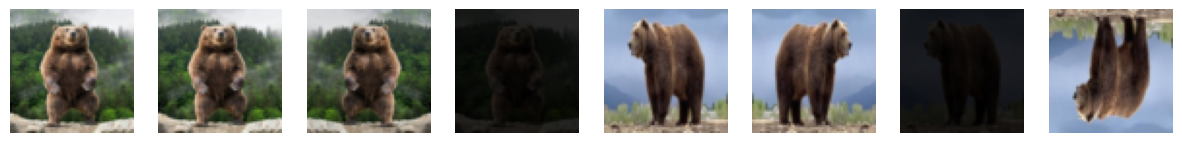

In [ ]:
print(f"Length of the dataset: {len(dataset)}")
import matplotlib.pyplot as plt
def visualize_images(dataset, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for i in range(num_images):
        # Get an image from the dataset
        image = dataset[i]["pixel_values"]  # Access the preprocessed tensor
        # Convert tensor to numpy and denormalize
        image = image.permute(1, 2, 0).cpu().numpy()  # Change from (C, H, W) to (H, W, C)
        image = (image * 0.5) + 0.5  # Denormalize from [-1, 1] to [0, 1]
        axes[i].imshow(image)
        axes[i].axis("off")
    plt.show()
visualize_images(dataset, num_images=8)

## Generate images from the trained model

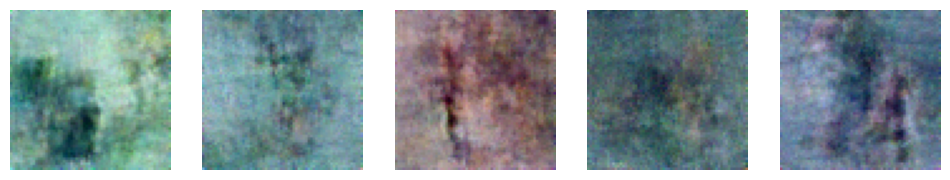

In [ ]:
import torch
from diffusers import DDPMScheduler, UNet2DModel
import matplotlib.pyplot as plt
model = UNet2DModel(
    sample_size=128,
    in_channels=3,
    out_channels=3,
    layers_per_block=2,
    block_out_channels=(64,128,256,512),
    down_block_types=("DownBlock2D","DownBlock2D","AttnDownBlock2D","AttnDownBlock2D"),
    up_block_types=("AttnUpBlock2D","AttnUpBlock2D","UpBlock2D","UpBlock2D"),
).to("cuda")
model.load_state_dict(torch.load("animal_diffusion_model.pth"))
model.eval()
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
noise_scheduler.set_timesteps(40)  # <<< FAST SAMPLING
def generate_images(num_images=5):
    with torch.no_grad():
        images = torch.randn((num_images,3,64,64)).to("cuda")
        for t in noise_scheduler.timesteps:
            t_batch = torch.full((num_images,), t, device="cuda", dtype=torch.long)
            noise_pred = model(images, t_batch).sample
            images = noise_scheduler.step(noise_pred, t, images).prev_sample
        images = (images.clamp(-1,1)+1)/2
        return images.cpu()
generated = generate_images(5)
fig, axes = plt.subplots(1,5, figsize=(12,3))
for i,img in enumerate(generated):
    axes[i].imshow(img.permute(1,2,0))
    axes[i].axis("off")
plt.show()

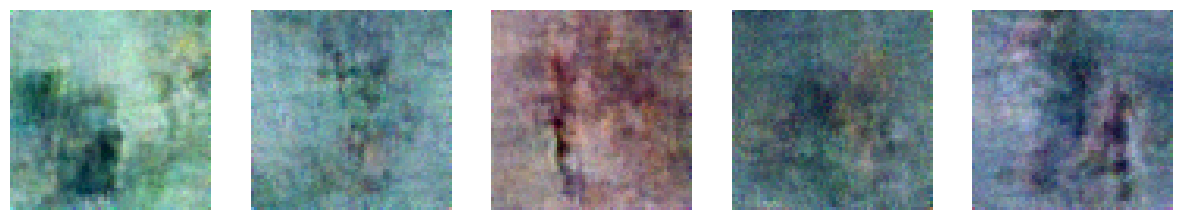

In [ ]:
import os
from matplotlib import pyplot as plt

# Create a directory to save the images
os.makedirs("images", exist_ok=True)

# Plot and save the generated images
fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
for i, img in enumerate(generated):
    img = img.permute(1, 2, 0)  # Change from (C, H, W) to (H, W, C)
    axes[i].imshow(img)
    axes[i].axis("off")

    # Save each image with a zero-padded two-digit number
    filename = f"images/animal_{i:02d}.png"
    plt.imsave(filename, img.numpy())

# Save the entire grid of images
plt.savefig("images/animal_grid.png")
plt.show()

In [ ]:
# !rm -rf images/

# Utility to zip a file
import shutil
shutil.make_archive("animals", "zip", "images")

'/content/animals.zip'